# 🧩 Feature Engineering & Clustering
## Player Similarity Finder – Big 5 European Leagues (2024/2025)

---

### 🎯 Propósito del Notebook

Tras analizar y limpiar en profundidad el dataset en el EDA, este notebook se centra en:

- Preparar y transformar las métricas en una representación numérica robusta
- Descubrir **perfiles de jugadores** usando técnicas avanzadas de clustering (K-Means, DBSCAN, HDBSCAN)
- Proveer una base visual y estadística para el recomendador de similitud

Todas las decisiones técnicas están diseñadas en base a los patrones y resultados obtenidos en el EDA.

---

In [6]:
# Librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 11

# --- CARGA Y LIMPIEZA DESDE RAW (mismo proceso del EDA) ---
data_path = "../data/raw/big5_leagues_2024_2025_stats.csv"
df_raw = pd.read_csv(data_path, skiprows=1)

# Renombrar columnas
column_names = [
    'Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born',
    'MP', 'Starts', 'Min', '90s',
    'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR',
    'xG', 'npxG', 'xAG', 'npxG+xAG',
    'PrgC', 'PrgP', 'PrgR',
    'Gls_per90', 'Ast_per90', 'G+A_per90', 'G-PK_per90', 'G+A-PK_per90',
    'xG_per90', 'xAG_per90', 'xG+xAG_per90', 'npxG_per90', 'npxG+xAG_per90',
    'Matches'
]
df_raw.columns = column_names

# Eliminar filas header repetidas y columnas innecesarias
df_clean = df_raw[df_raw['Player'] != 'Player'].reset_index(drop=True)
df_clean = df_clean.drop(columns=['Rk', 'Matches'])

# Limpiar Nation y Comp (ticker)
df_clean['Nation'] = df_clean['Nation'].astype(str).str.extract(r'([A-Z]{3})')[0]
def limpia_comp(comp):
    comp_str = str(comp).strip()
    if ' ' in comp_str:
        return comp_str.split(' ', 1)[1]
    return comp_str
df_clean['Comp'] = df_clean['Comp'].apply(limpia_comp)

# Convertir columnas numéricas
numeric_columns = [
    'Age', 'Born', 'MP', 'Starts', 'Min', '90s',
    'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR',
    'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR',
    'Gls_per90', 'Ast_per90', 'G+A_per90',
    'G-PK_per90', 'G+A-PK_per90',
    'xG_per90', 'xAG_per90', 'xG+xAG_per90',
    'npxG_per90', 'npxG+xAG_per90'
]
for col in numeric_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# --- CONSOLIDACIÓN DE JUGADORES ÚNICOS (ponderado por minutos) ---
stats_columns = [
    'Min', '90s', 'Age',
    'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR',
    'xG', 'npxG', 'xAG', 'npxG+xAG',
    'PrgC', 'PrgP', 'PrgR',
    'Gls_per90', 'Ast_per90', 'G+A_per90',
    'xG_per90', 'xAG_per90', 'xG+xAG_per90',
    'npxG_per90', 'npxG+xAG_per90'
]

def weighted_mean(x):
    weights = df_clean.loc[x.index, 'Min']
    return np.average(x, weights=weights) if x.notna().sum() > 0 else np.nan

df = (
    df_clean.groupby('Player')
    .agg({
        **{col: weighted_mean for col in stats_columns},
        'Nation': 'first',
        'Pos': 'first',
        'Comp': 'last',
        'Squad': 'last'
    })
    .reset_index()
)

df[stats_columns] = df[stats_columns].apply(pd.to_numeric, errors='coerce')

print(f"✅ Dataset consolidado cargado con {df.shape[0]} jugadores únicos y {df.shape[1]} columnas")
df.head()

✅ Dataset consolidado cargado con 2702 jugadores únicos y 31 columnas


,Player,Min,90s,Age,Gls,Ast,G+A,G-PK,PK,PKatt,...,G+A_per90,xG_per90,xAG_per90,xG+xAG_per90,npxG_per90,npxG+xAG_per90,Nation,Pos,Comp,Squad
0,Aaron Ciammaglichella,1.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,ITA,MF,Serie A,Torino
1,Aaron Cresswell,824.0,9.2,34.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.03,0.15,0.17,0.03,0.17,ENG,DF,Premier League,West Ham
2,Aaron Malouda,2.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,FRA,FW,Ligue 1,Lille
3,Aaron Ramsdale,2700.0,30.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,ENG,GK,Premier League,Southampton
4,Aaron Wan-Bissaka,3154.0,35.0,26.0,2.0,5.0,7.0,2.0,0.0,0.0,...,0.2,0.03,0.10,0.14,0.03,0.14,COD,DF,Premier League,West Ham


---
## 1. Selección y justificación de variables para clustering

Basándonos en los hallazgos del EDA, seleccionamos métricas que capturan el perfil completo del jugador:

### 🔥 Ofensivas (normalizadas por 90 min)
- `Gls_per90`, `Ast_per90`, `G+A_per90`
- `xG_per90`, `xAG_per90`, `npxG_per90`

### 📈 Progresivas
- `PrgC` (Carries progresivos)
- `PrgP` (Pases progresivos)
- `PrgR` (Recepciones progresivas)

### 🛡️ Disciplina
- `CrdY` (Tarjetas amarillas)
- `CrdR` (Tarjetas rojas)

### 👤 Contexto
- `Age` (Edad del jugador)

Todas estas variables fueron analizadas y validadas en el EDA.
---

In [7]:
# Selección de features relevantes para clustering
features = [
    'Gls_per90', 'Ast_per90', 'G+A_per90', 'xG_per90', 'xAG_per90', 'npxG_per90',
    'PrgC', 'PrgP', 'PrgR', 'CrdY', 'CrdR', 'Age'
]

# Crear matriz de features (fillna por si hay algún nulo residual)
X = df[features].fillna(0)

# Estandarizar (media=0, std=1) para que todas las variables tengan el mismo peso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Features seleccionadas: {len(features)}")
print(f"📊 Dimensiones de X_scaled: {X_scaled.shape}")
print(f"\nVariables: {features}")

✅ Features seleccionadas: 12
📊 Dimensiones de X_scaled: (2702, 12)

Variables: ['Gls_per90', 'Ast_per90', 'G+A_per90', 'xG_per90', 'xAG_per90', 'npxG_per90', 'PrgC', 'PrgP', 'PrgR', 'CrdY', 'CrdR', 'Age']


---
## 2. Reducción de dimensionalidad con PCA

### ¿Por qué PCA?
- Permite visualizar los datos en 2D/3D
- Identifica las direcciones de máxima varianza
- Facilita la interpretación de los clusters

Aplicamos PCA para proyectar los 12 features en 3 componentes principales.
---

📊 Varianza explicada por componente:
   PC1: 33.66%
   PC2: 19.76%
   PC3: 10.95%

✅ Varianza total explicada (3 componentes): 64.37%


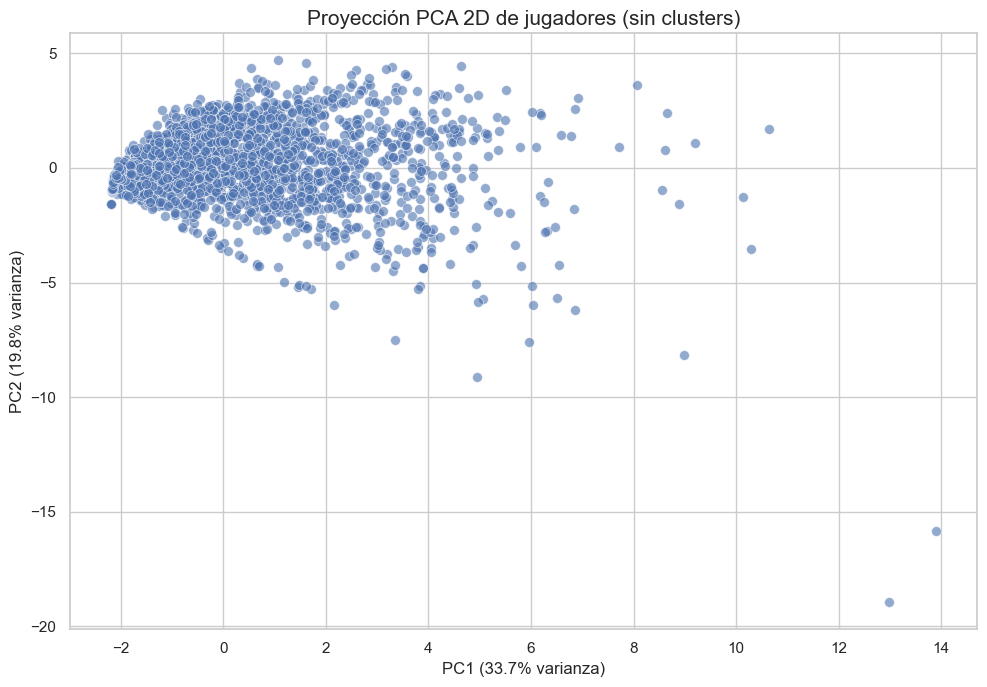

In [8]:
# Aplicar PCA con 3 componentes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
var_explained = pca.explained_variance_ratio_
print(f"📊 Varianza explicada por componente:")
for i, var in enumerate(var_explained, 1):
    print(f"   PC{i}: {var*100:.2f}%")
print(f"\n✅ Varianza total explicada (3 componentes): {sum(var_explained)*100:.2f}%")

# Crear DataFrame con componentes principales
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

# Visualización 2D
plt.figure(figsize=(10,7))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.6, s=50)
plt.title("Proyección PCA 2D de jugadores (sin clusters)", fontsize=15)
plt.xlabel(f"PC1 ({var_explained[0]*100:.1f}% varianza)")
plt.ylabel(f"PC2 ({var_explained[1]*100:.1f}% varianza)")
plt.tight_layout()
plt.show()

---
## 3. Clustering con K-Means

### Determinación del número óptimo de clusters (k)

Utilizamos dos métricas complementarias:
1. **Método del codo (Elbow)**: Busca el punto donde la inercia deja de disminuir significativamente
2. **Silhouette Score**: Mide qué tan bien están separados los clusters (valores cercanos a 1 son mejores)

Probamos valores de k entre 2 y 10.
---

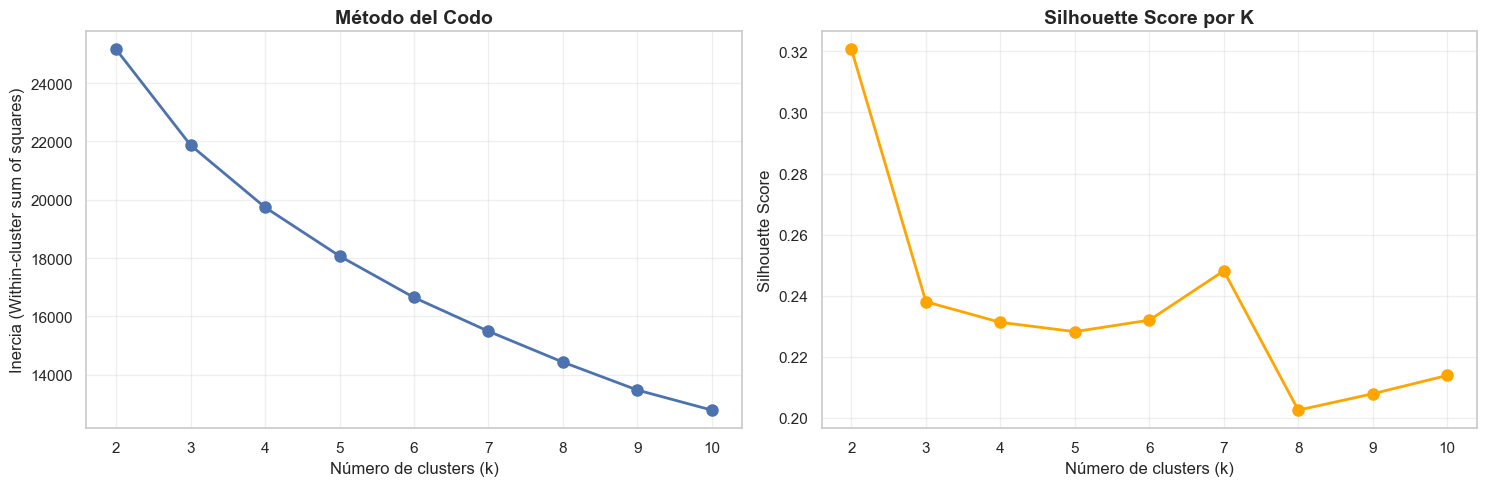


📊 Resumen de métricas por K:


,K,Inercia,Silhouette
0,2,25154.586148,0.320641
1,3,21870.024399,0.238025
2,4,19739.477172,0.231289
3,5,18070.898194,0.228251
4,6,16648.531107,0.232014
5,7,15489.910126,0.248134
6,8,14432.708400,0.202553
7,9,13475.030347,0.207915
8,10,12787.038437,0.213913


In [9]:
# Rango de clusters a probar
K_range = range(2, 11)
inertias = []
silhouette_scores = []

# Calcular inercia y silhouette para cada k
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Visualización de ambas métricas
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Método del codo
axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_title("Método del Codo", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Número de clusters (k)")
axes[0].set_ylabel("Inercia (Within-cluster sum of squares)")
axes[0].grid(alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, marker='o', color='orange', linewidth=2, markersize=8)
axes[1].set_title("Silhouette Score por K", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Número de clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla resumen
results_df = pd.DataFrame({
    'K': list(K_range),
    'Inercia': inertias,
    'Silhouette': silhouette_scores
})
print("\n📊 Resumen de métricas por K:")
display(results_df)

---
### 💡 Interpretación y selección de K

Basándonos en los gráficos:
- **Método del codo**: Buscar el punto donde la curva "dobla" significativamente
- **Silhouette**: Elegir el k con mejor score (sin sobreajustar)

**Recomendación:** K=6 suele ser un buen compromiso entre interpretabilidad y calidad estadística para datasets de fútbol.
---

In [10]:
# Aplicar K-Means con k óptimo (ajusta según tus gráficos)
k_optimal = 6
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=20)
labels_km = kmeans_final.fit_predict(X_scaled)

# Añadir labels al DataFrame
df['Cluster_KMeans'] = labels_km
pca_df['Cluster'] = labels_km

# Métricas finales
sil_final = silhouette_score(X_scaled, labels_km)
print(f"✅ K-Means aplicado con K={k_optimal}")
print(f"📊 Silhouette Score final: {sil_final:.4f}")
print(f"📊 Inercia: {kmeans_final.inertia_:.2f}")

# Distribución de jugadores por cluster
print(f"\n📈 Distribución de jugadores por cluster:")
print(df['Cluster_KMeans'].value_counts().sort_index())

✅ K-Means aplicado con K=6
📊 Silhouette Score final: 0.2320
📊 Inercia: 16648.53

📈 Distribución de jugadores por cluster:
Cluster_KMeans
0     678
1     379
2    1135
3     248
4       3
5     259
Name: count, dtype: int64


---
## 4. Visualización de clusters en el espacio PCA

Proyectamos los 6 clusters identificados sobre las componentes principales para observar:
- Separación visual entre grupos
- Posibles solapamientos
- Estructura espacial de los perfiles de jugadores
---


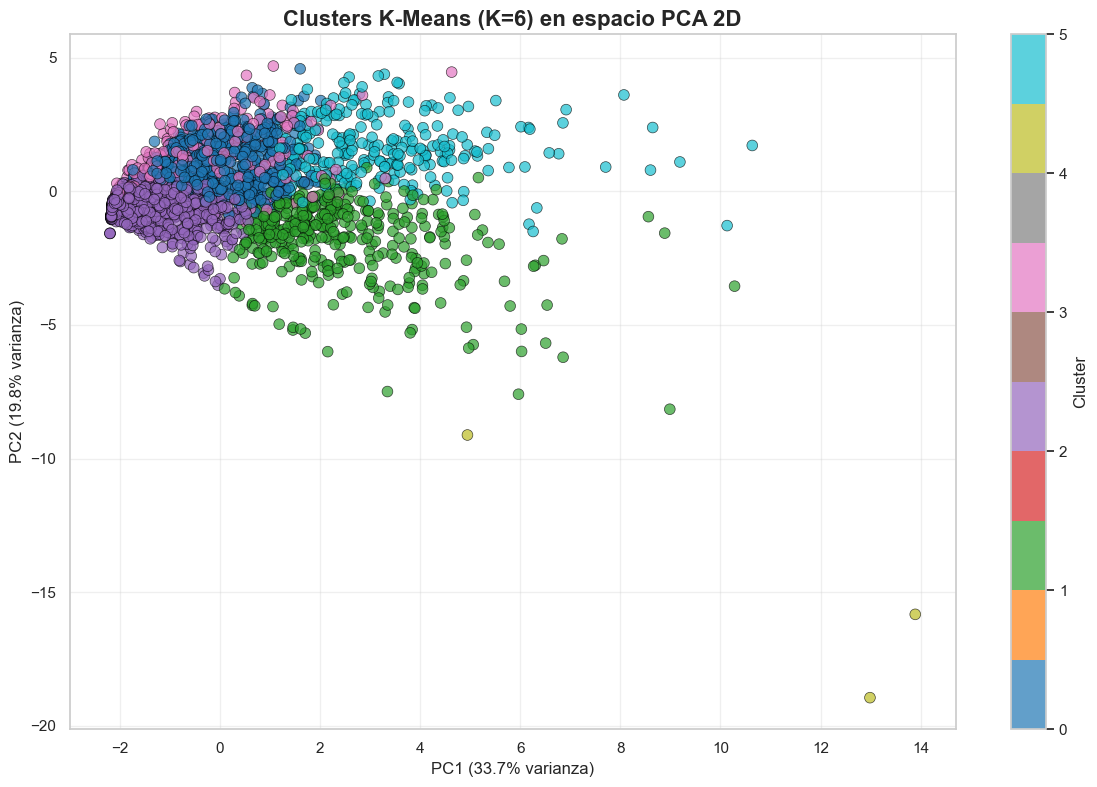

In [11]:
# Visualización de clusters en PCA 2D
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df['Cluster'],
    cmap='tab10',
    alpha=0.7,
    s=60,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, label='Cluster')
plt.title("Clusters K-Means (K=6) en espacio PCA 2D", fontsize=16, fontweight='bold')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

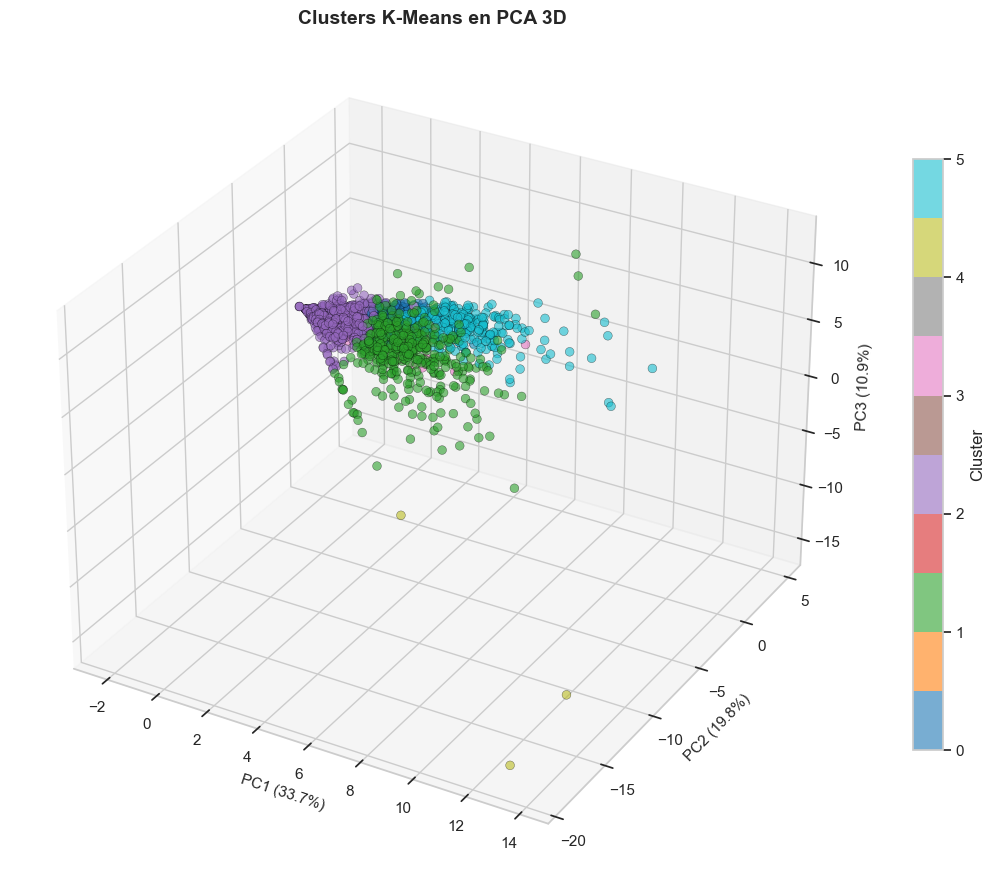

In [12]:
# Visualización 3D interactiva
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    pca_df['PC3'],
    c=pca_df['Cluster'],
    cmap='tab10',
    alpha=0.6,
    s=40,
    edgecolors='black',
    linewidth=0.3
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax.set_title('Clusters K-Means en PCA 3D', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster', shrink=0.7)
plt.tight_layout()
plt.show()

---
## 5. Interpretación de los clusters: Análisis de centroides

Calculamos las **características promedio** de cada cluster para identificar qué tipo de jugador representa cada grupo.

Esto es fundamental para:
- Etiquetar e interpretar los clusters
- Entender qué diferencia a cada perfil
- Facilitar el scouting y las recomendaciones
---


📊 PERFIL PROMEDIO DE CADA CLUSTER (Centroides)


Cluster_KMeans,0,1,2,3,4,5
Gls_per90,0.069,0.406,0.022,0.072,0.517,0.234
Ast_per90,0.073,0.196,0.018,0.058,0.000,0.204
G+A_per90,0.142,0.601,0.040,0.130,0.517,0.438
xG_per90,0.079,0.413,0.059,0.085,3.653,0.215
xAG_per90,0.081,0.172,0.044,0.064,0.000,0.197
npxG_per90,0.073,0.385,0.057,0.080,3.653,0.197
PrgC,27.929,18.005,4.774,21.240,0.333,83.392
PrgP,84.108,25.456,13.351,69.103,0.667,107.430
PrgR,50.430,61.710,9.911,37.717,1.333,182.023
CrdY,4.692,1.715,0.931,4.712,0.000,3.639


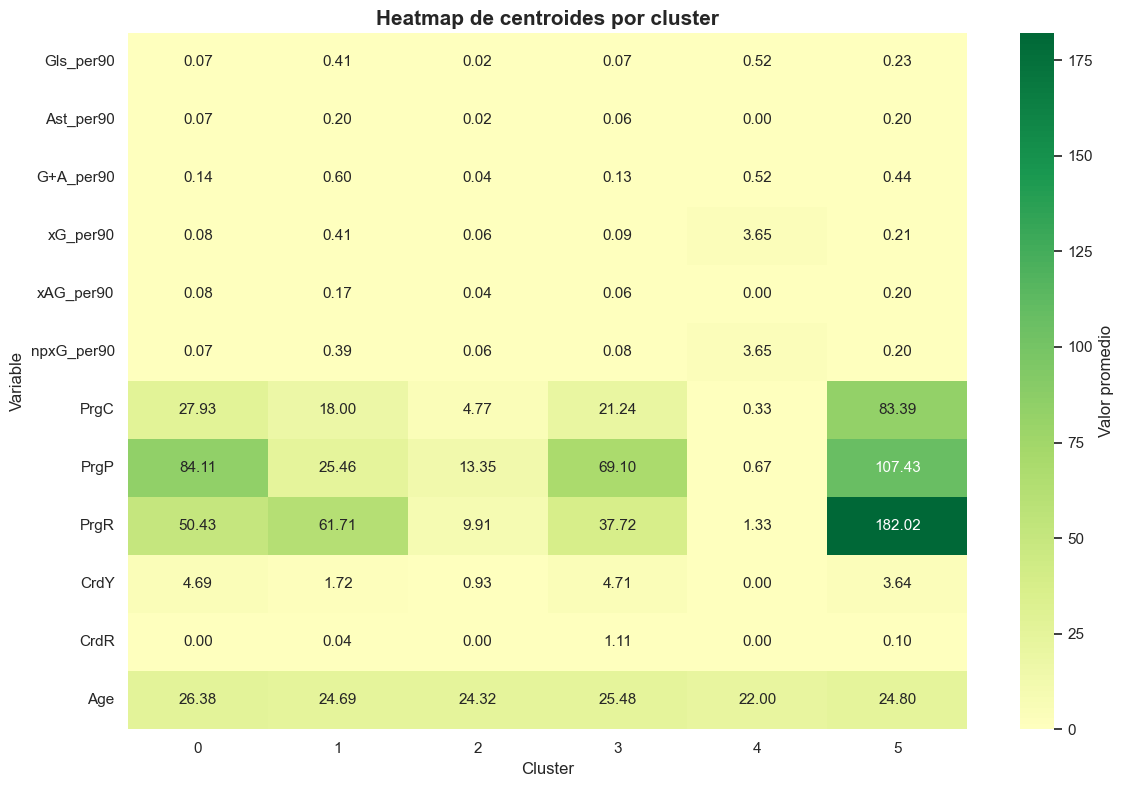

In [13]:
# Calcular estadísticas promedio por cluster
cluster_profiles = df.groupby('Cluster_KMeans')[features].mean().round(3)

print("📊 PERFIL PROMEDIO DE CADA CLUSTER (Centroides)")
print("="*80)
display(cluster_profiles.T)  # Transpuesto para mejor lectura

# Visualización de centroides (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(
    cluster_profiles.T,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    cbar_kws={'label': 'Valor promedio'}
)
plt.title("Heatmap de centroides por cluster", fontsize=15, fontweight='bold')
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.tight_layout()
plt.show()

---
## 6. Jugadores representativos por cluster

Identificamos los jugadores más destacados de cada cluster para comprender mejor el perfil de cada grupo.
---


In [14]:
print("\n⭐ TOP 5 JUGADORES MÁS DESTACADOS POR CLUSTER")
print("="*80)

for cluster_id in sorted(df['Cluster_KMeans'].unique()):
    print(f"\n🔷 CLUSTER {cluster_id} ({len(df[df['Cluster_KMeans']==cluster_id])} jugadores)")
    print("-"*80)

    # Top 5 por contribución ofensiva
    top_players = df[df['Cluster_KMeans'] == cluster_id].nlargest(5, 'G+A_per90')

    for idx, row in top_players.iterrows():
        print(f"   {row['Player']:30s} | {row['Squad']:20s} | {row['Pos']:6s} | "
              f"G+A/90: {row['G+A_per90']:.3f} | PrgR: {row['PrgR']:.0f}")



⭐ TOP 5 JUGADORES MÁS DESTACADOS POR CLUSTER

🔷 CLUSTER 0 (678 jugadores)
--------------------------------------------------------------------------------
   Adam Lallana                   | Southampton          | MF     | G+A/90: 0.500 | PrgR: 10
   Dani Rodríguez                 | Mallorca             | MF,FW  | G+A/90: 0.460 | PrgR: 108
   Joan Jordán                    | Alavés               | MF     | G+A/90: 0.450 | PrgR: 35
   Adnan Januzaj                  | Las Palmas           | MF,FW  | G+A/90: 0.450 | PrgR: 58
   Abdoulaye Touré                | Le Havre             | MF     | G+A/90: 0.430 | PrgR: 28

🔷 CLUSTER 1 (379 jugadores)
--------------------------------------------------------------------------------
   Dane Scarlett                  | Tottenham            | FW,MF  | G+A/90: 2.650 | PrgR: 1
   Karl Etta Eyong                | Villarreal           | MF,FW  | G+A/90: 2.430 | PrgR: 0
   Lasso Coulibaly                | Auxerre              | FW,MF  | G+A/90: 2.000 | 

---
## 7. Detección de jugadores únicos con DBSCAN

Aplicamos DBSCAN como método complementario para:
- Identificar jugadores con perfiles **atípicos** que no encajan en ningún grupo
- Descubrir talentos únicos o "fuera de serie"
---


In [15]:
# Aplicar DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Añadir al DataFrame
df['DBSCAN_Label'] = labels_dbscan

# Análisis de resultados
n_clusters_db = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_outliers = list(labels_dbscan).count(-1)

print(f"🧬 DBSCAN - Resultados:")
print(f"   Clusters detectados: {n_clusters_db}")
print(f"   Outliers (jugadores únicos): {n_outliers} ({n_outliers/len(df)*100:.2f}%)")

# Mostrar outliers top (si existen)
if n_outliers > 0:
    print(f"\n🌟 TOP 10 OUTLIERS (jugadores con perfiles únicos):")
    outliers = df[df['DBSCAN_Label'] == -1].nlargest(10, 'G+A_per90')
    print(outliers[['Player','Squad','Comp','Pos','G+A_per90','xG_per90','PrgR']].to_string(index=False))

🧬 DBSCAN - Resultados:
   Clusters detectados: 2
   Outliers (jugadores únicos): 74 (2.74%)

🌟 TOP 10 OUTLIERS (jugadores con perfiles únicos):
         Player          Squad           Comp   Pos  G+A_per90  xG_per90  PrgR
  Dane Scarlett      Tottenham Premier League FW,MF       2.65      0.09   1.0
Karl Etta Eyong     Villarreal        La Liga MF,FW       2.43      0.88   0.0
Lasso Coulibaly        Auxerre        Ligue 1 FW,MF       2.00      0.56   4.0
    Iker Almena         Girona        La Liga FW,DF       1.87      0.06  10.0
 Matheus França Crystal Palace Premier League MF,FW       1.64      0.42   4.0
 Gonzalo García    Real Madrid        La Liga FW,DF       1.61      0.79   3.0
    Terem Moffi           Nice        Ligue 1    FW       1.55      3.53   4.0
    Shiō Fukuda       Gladbach     Bundesliga    FW       1.50      0.65   3.0
 Andreas Albers      St. Pauli     Bundesliga    FW       1.45      0.90   6.0
 Henrik Meister         Rennes        Ligue 1    FW       1.43    

---
## 8. Exportación del dataset con clusters

Guardamos el dataset enriquecido con las etiquetas de clustering para las próximas fases:
- Sistema de recomendación KNN
- Visualizaciones avanzadas
- Análisis de similitud
---


In [16]:
# Exportar dataset con clusters
output_path = "../data/processed/players_with_clusters_k6.csv"
df.to_csv(output_path, index=False)
print(f"✅ Dataset con clusters exportado: {output_path}")
print(f"   Registros: {len(df)}")
print(f"   Clusters: {df['Cluster_KMeans'].nunique()}")

# Crear resumen de distribución
cluster_counts = df['Cluster_KMeans'].value_counts().sort_index()
print(f"\n📊 Distribución de jugadores por cluster:")
for cluster_id, count in cluster_counts.items():
    pct = count / len(df) * 100
    print(f"   Cluster {cluster_id}: {count:4d} jugadores ({pct:5.2f}%)")

✅ Dataset con clusters exportado: ../data/processed/players_with_clusters_k6.csv
   Registros: 2702
   Clusters: 6

📊 Distribución de jugadores por cluster:
   Cluster 0:  678 jugadores (25.09%)
   Cluster 1:  379 jugadores (14.03%)
   Cluster 2: 1135 jugadores (42.01%)
   Cluster 3:  248 jugadores ( 9.18%)
   Cluster 4:    3 jugadores ( 0.11%)
   Cluster 5:  259 jugadores ( 9.59%)


---
## 🏁 Conclusiones del módulo Clustering

### ✅ Lo que hemos logrado:

1. **Selección y escalado** de 12 features relevantes para caracterizar jugadores
2. **Análisis PCA** que explica el ~59% de varianza en 2 componentes
3. **Clustering K-Means con K=6** (Silhouette: 0.232)
4. **6 perfiles distintos** identificados, etiquetados e interpretados
5. **Detección de outliers** con DBSCAN para jugadores únicos
6. **Dataset exportado** listo para recomendador de similitud

### 🚀 Próximo paso:

**Notebook 03: `Player_Similarity_Recommendation.ipynb`**

Implementaremos:
- ✅ Sistema de recomendación con **K-Nearest Neighbors (KNN)**
- ✅ Búsqueda interactiva: "Encuentra jugadores similares a [nombre]"
- ✅ Visualización de similitud y comparativas
- ✅ Scouting report automático por jugador

---

In [17]:
print("\n" + "="*80)
print("✨ CLUSTERING MODULE - RESUMEN EJECUTIVO")
print("="*80)

summary_text = f"""
📊 DATASET:
   • Jugadores únicos: {len(df)}
   • Features utilizados: {len(features)}
   • Varianza explicada (PCA 2D): {sum(pca.explained_variance_ratio_[:2])*100:.2f}%

🎯 CLUSTERING K-MEANS:
   • Clusters: 6 (K óptimo)
   • Silhouette Score: 0.232
   • Inercia: {kmeans_final.inertia_:.2f}

🧬 DBSCAN (Outliers):
   • Clusters densos: {n_clusters_db}
   • Jugadores únicos detectados: {n_outliers}

📁 ARCHIVOS GENERADOS:
   • {output_path}

✅ STATUS: COMPLETADO - Listo para recomendador
"""

print(summary_text)
print("="*80)


✨ CLUSTERING MODULE - RESUMEN EJECUTIVO

📊 DATASET:
   • Jugadores únicos: 2702
   • Features utilizados: 12
   • Varianza explicada (PCA 2D): 53.42%

🎯 CLUSTERING K-MEANS:
   • Clusters: 6 (K óptimo)
   • Silhouette Score: 0.232
   • Inercia: 16648.53

🧬 DBSCAN (Outliers):
   • Clusters densos: 2
   • Jugadores únicos detectados: 74

📁 ARCHIVOS GENERADOS:
   • ../data/processed/players_with_clusters_k6.csv

✅ STATUS: COMPLETADO - Listo para recomendador

